# Problem statement:
---
A very basic cat not a cat image recognition. this was taken from the C1W4 DL specialization's last assignment, but doing it using tf instead of coding it using only numpy.

In [1]:
# Importing packages:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [2]:
# Loading the data:

def load_data():
    train_dataset = h5py.File('../Datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('../Datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

In [3]:
# exploring the data:

print(f'train_x_orig shape: {train_x_orig.shape}')
print(f'train_y shape: {train_y.shape}')
print(f'test_x_orig shape: {test_x_orig.shape}')
print(f'test_y shape: {test_y.shape}')

train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


We have 209 training examples, and 50 testing examples, each of them is a 64 * 64 * 3 picture.
We need to flatten them for further analysis.

In [4]:
classes

array([b'non-cat', b'cat'], dtype='|S7')

In [5]:
x_train = train_x_orig.reshape(209,-1)
x_test = test_x_orig.reshape(50,-1)

print(f'x_train shape: {x_train.shape}')
print(f'x_test shape: {x_test.shape}')

x_train shape: (209, 12288)
x_test shape: (50, 12288)


displaying 16 random images of the data:

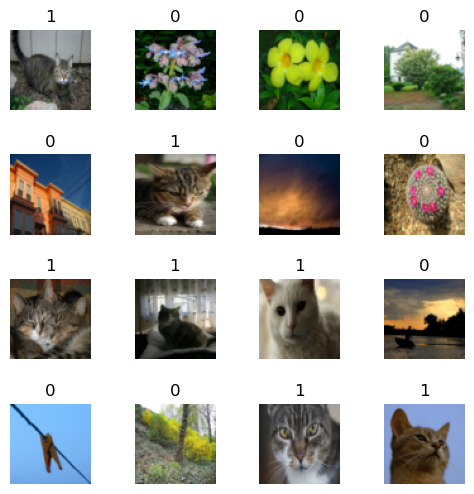

In [6]:
m,n = x_train.shape

fig, ax = plt.subplots(4,4,figsize=(5,5))
fig.tight_layout(pad=0.1)

for i, ax in enumerate(ax.flat):
    rand = np.random.randint(m)
    
    ax.imshow(x_train[rand].reshape(64,64,3), cmap='gray')
    ax.set_title(train_y.T[rand][0])
    ax.set_axis_off()

In [7]:
# feature scaling:
x_test = x_test/255
x_train = x_train/255

# Logistic Regression:
---

In [8]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=500)
model.fit(x_train, train_y.T.ravel())

LogisticRegression(max_iter=500)

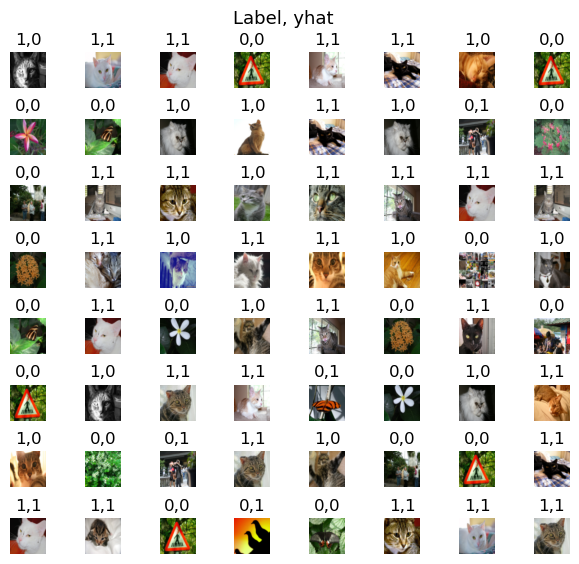

In [9]:
fig, ax = plt.subplots(8,8, figsize=(6,6))
fig.tight_layout(pad=0.1,rect=[0, 0.03, 1, 0.92])
m,n = x_test.shape

for i, ax in enumerate(ax.flat):
    rand = np.random.randint(m)
    
    prediction = model.predict(x_test[rand].reshape(1,12288))
    if prediction >= 0.5:
        yhat=1
    else:
        yhat=0
    
    ax.imshow(x_test[rand].reshape(64,64,3))
    true = test_y.T[rand][0]
    ax.set_title(f'{true},{yhat}')
    ax.set_axis_off()
fig.suptitle("Label, yhat", fontsize=13);

In [10]:
prediction=np.zeros(x_test.shape[0])
for i in range(50):
    predict = model.predict(x_test[i].reshape(1,12288))
    if predict >= 0.5:
        yhat=1
    else:
        yhat=0
    prediction[i] = yhat

prediction

array([1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0.])

In [11]:
test_y.shape

(1, 50)

In [12]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(prediction.ravel(),test_y.T)
acc

0.72

We achieved 72% accuracy using logistic regression.

# Neural Networks:
---

In [13]:
regularizer = tf.keras.regularizers.L2(0.5)

model = tf.keras.models.Sequential([
                                    tf.keras.Input(shape=(12288,)),
                                    tf.keras.layers.Dropout(0.25),
                                    tf.keras.layers.Dense(units=70, activation='relu'),# kernel_regularizer=regularizer),
                                    tf.keras.layers.Dense(units=15, activation='relu'),# kernel_regularizer=regularizer),
                                    tf.keras.layers.Dense(units=1, activation='sigmoid')
                                    ])
        
                

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 70)                860230    
                                                                 
 dense_1 (Dense)             (None, 15)                1065      
                                                                 
 dense_2 (Dense)             (None, 1)                 16        
                                                                 
Total params: 861,311
Trainable params: 861,311
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(0.000007),
              metrics='accuracy'
             )

In [16]:
history = model.fit(x_train, 
                    train_y.T,
                    epochs=500,
                   validation_data = (x_test, test_y.T))

Epoch 1/500
7/7 [==============================] - 1s 53ms/step - loss: 0.7405 - accuracy: 0.4402 - val_loss: 0.6830 - val_accuracy: 0.6200
Epoch 2/500
7/7 [==============================] - 0s 26ms/step - loss: 0.6683 - accuracy: 0.6220 - val_loss: 0.8265 - val_accuracy: 0.3400
Epoch 3/500
7/7 [==============================] - 0s 23ms/step - loss: 0.6563 - accuracy: 0.6699 - val_loss: 0.8833 - val_accuracy: 0.3400
Epoch 4/500
7/7 [==============================] - 0s 19ms/step - loss: 0.6644 - accuracy: 0.6459 - val_loss: 0.8873 - val_accuracy: 0.3400
Epoch 5/500
7/7 [==============================] - 0s 18ms/step - loss: 0.6488 - accuracy: 0.6459 - val_loss: 0.8466 - val_accuracy: 0.3400
Epoch 6/500
7/7 [==============================] - 0s 18ms/step - loss: 0.6583 - accuracy: 0.6507 - val_loss: 0.7998 - val_accuracy: 0.3400
Epoch 7/500
7/7 [==============================] - 0s 18ms/step - loss: 0.6485 - accuracy: 0.6507 - val_loss: 0.7881 - val_accuracy: 0.3400
Epoch 8/500
7/7 [===

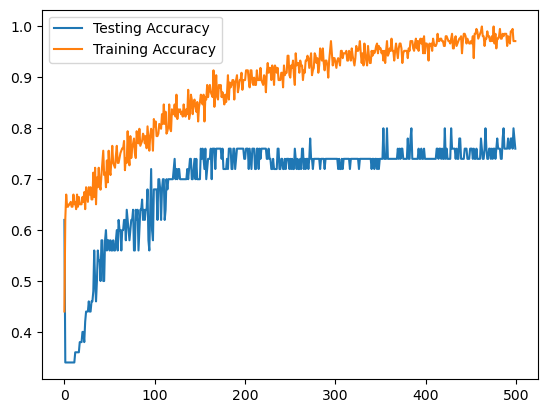

In [17]:
plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.legend()

1/1 [==============================] - 0s 17ms/step


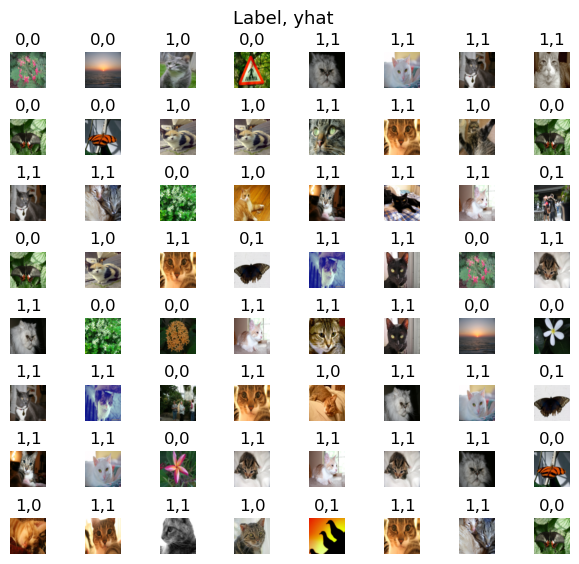

In [18]:
fig, ax = plt.subplots(8,8, figsize=(6,6))
fig.tight_layout(pad=0.1,rect=[0, 0.03, 1, 0.92])
m,n = x_test.shape

for i, ax in enumerate(ax.flat):
    rand = np.random.randint(m)
    
    prediction = model.predict(x_test[rand].reshape(1,12288))
    if prediction >= 0.5:
        yhat=1
    else:
        yhat=0
    
    ax.imshow(x_test[rand].reshape(64,64,3))
    true = test_y.T[rand][0]
    ax.set_title(f'{true},{yhat}')
    ax.set_axis_off()
fig.suptitle("Label, yhat", fontsize=13);

In [19]:
model.evaluate(x_test,test_y.T)

2/2 [==============================] - 0s 4ms/step - loss: 0.5782 - accuracy: 0.7600


[0.5782001614570618, 0.7599999904632568]

We increased the accuracy to 78%.

# CNN:
---

In [20]:
model = tf.keras.Sequential([
                            tf.keras.layers.Conv2D(32,3, activation='relu', input_shape=(64,64,3)),
                            tf.keras.layers.Conv2D(32,3, activation='relu'),
                            tf.keras.layers.MaxPool2D(),
                            tf.keras.layers.BatchNormalization(),
                            tf.keras.layers.Conv2D(64,3, activation='relu'),
                            tf.keras.layers.Conv2D(64,3, activation='relu'),
                            tf.keras.layers.MaxPool2D(),
                            tf.keras.layers.BatchNormalization(),
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dense(1024, activation='relu'),
                            tf.keras.layers.Dense(1, activation='sigmoid')
                            ])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 64)       

In [21]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics='acc')

# Data Augmentation:
---

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_generator = ImageDataGenerator(rotation_range=180,
                                    zoom_range=0.6,
                                    horizontal_flip=True,
                                    width_shift_range=0.5,
                                    height_shift_range=0.5)

train_gen = data_generator.flow(x_train.reshape(209,64,64,3), train_y.T)
test_gen = data_generator.flow(x_test.reshape(50,64,64,3), test_y.T)

In [23]:
history = model.fit(train_gen, 
                    epochs = 50, 
                    validation_data = test_gen
                    )

Epoch 1/50
7/7 [==============================] - 4s 470ms/step - loss: 5.0995 - acc: 0.5694 - val_loss: 0.8935 - val_acc: 0.3800
Epoch 2/50
7/7 [==============================] - 4s 538ms/step - loss: 3.9020 - acc: 0.6842 - val_loss: 0.8148 - val_acc: 0.4600
Epoch 3/50
7/7 [==============================] - 4s 495ms/step - loss: 3.0921 - acc: 0.6938 - val_loss: 0.8382 - val_acc: 0.3800
Epoch 4/50
7/7 [==============================] - 3s 445ms/step - loss: 2.3888 - acc: 0.6986 - val_loss: 0.7987 - val_acc: 0.3600
Epoch 5/50
7/7 [==============================] - 3s 492ms/step - loss: 2.1015 - acc: 0.7177 - val_loss: 1.0525 - val_acc: 0.3400
Epoch 6/50
7/7 [==============================] - 3s 486ms/step - loss: 1.6589 - acc: 0.7273 - val_loss: 0.7590 - val_acc: 0.3400
Epoch 7/50
7/7 [==============================] - 3s 445ms/step - loss: 0.9736 - acc: 0.6938 - val_loss: 0.7949 - val_acc: 0.3400
Epoch 8/50
7/7 [==============================] - 3s 461ms/step - loss: 0.8630 - acc: 0.69

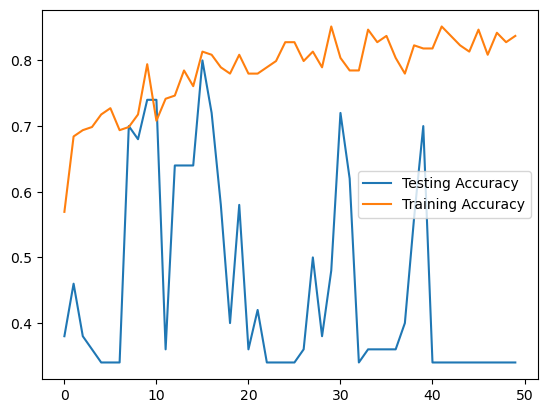

In [24]:
plt.plot(history.history['val_acc'], label='Testing Accuracy')
plt.plot(history.history['acc'], label='Training Accuracy')
plt.legend()

# Transfer Learning:
---

In [25]:
from tensorflow.keras.applications import ResNet50V2
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape = (64,64,3))

In [26]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 34, 34, 64)   0           ['conv1_conv[0][0]']             
                                                                                         

In [27]:
base_model.trainable = False

In [28]:
x = base_model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, 'relu')(x)
x = tf.keras.layers.Dense(1, 'sigmoid')(x)
model = tf.keras.Model(inputs = base_model.input, outputs = x)

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 34, 34, 64)   0           ['conv1_conv[0][0]']             
                                                                                              

In [30]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics='acc')

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath='cats_detection_weights.hdf5',verbose=1,  save_best_only=True)

In [32]:
history = model.fit(train_gen, 
                    epochs = 150, 
                    validation_data = test_gen,
                    callbacks=checkpoint)

Epoch 1/150
7/7 [==============================] - ETA: 0s - loss: 2.3461 - acc: 0.6603
Epoch 1: val_loss improved from inf to 1.41403, saving model to cats_detection_weights.hdf5
7/7 [==============================] - 7s 616ms/step - loss: 2.3461 - acc: 0.6603 - val_loss: 1.4140 - val_acc: 0.7000
Epoch 2/150
7/7 [==============================] - ETA: 0s - loss: 0.9991 - acc: 0.7990
Epoch 2: val_loss did not improve from 1.41403
7/7 [==============================] - 2s 355ms/step - loss: 0.9991 - acc: 0.7990 - val_loss: 2.4575 - val_acc: 0.6200
Epoch 3/150
7/7 [==============================] - ETA: 0s - loss: 1.0678 - acc: 0.7895
Epoch 3: val_loss did not improve from 1.41403
7/7 [==============================] - 2s 367ms/step - loss: 1.0678 - acc: 0.7895 - val_loss: 1.5139 - val_acc: 0.8200
Epoch 4/150
7/7 [==============================] - ETA: 0s - loss: 0.6636 - acc: 0.7990
Epoch 4: val_loss improved from 1.41403 to 0.41286, saving model to cats_detection_weights.hdf5
7/7 [====

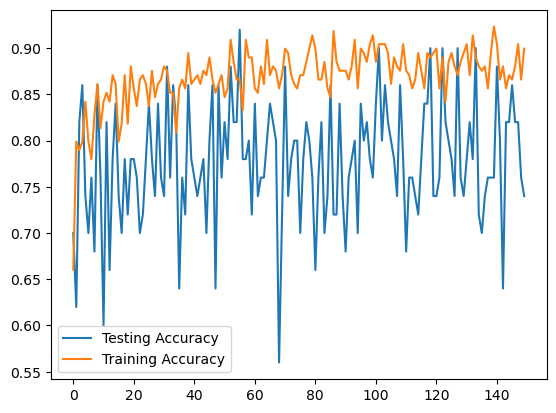

In [33]:
plt.plot(history.history['val_acc'], label='Testing Accuracy')
plt.plot(history.history['acc'], label='Training Accuracy')
plt.legend()

In [49]:
model.load_weights('cats_detection_weights.hdf5')

####  The Best result was using transfer learning, and with which the validation accuracy were 92%.